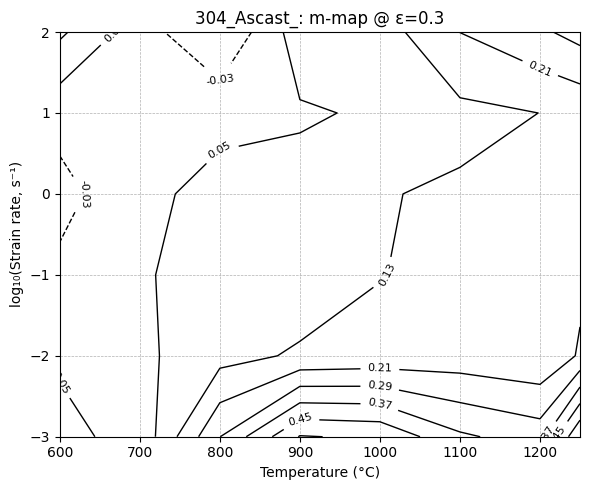

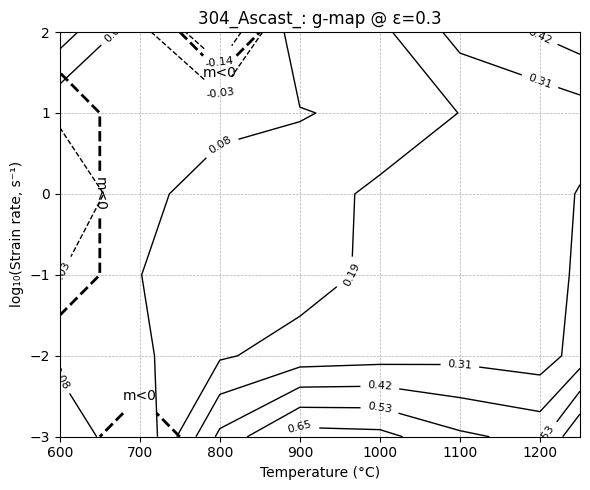

Saved processing maps for '304_Ascast_' to /content/304_Ascast__processing_maps.pdf


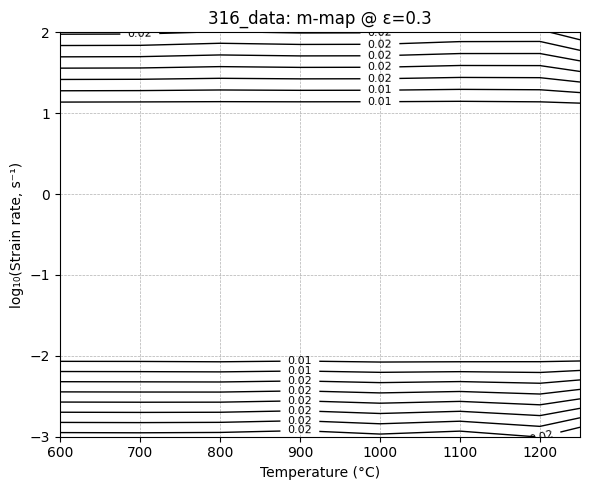

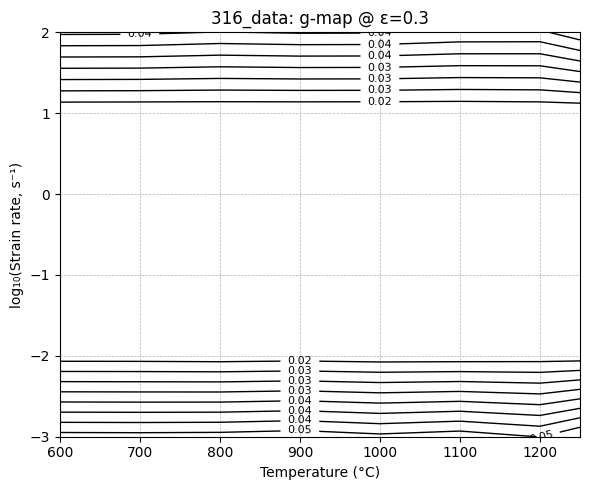

Saved processing maps for '316_data' to /content/316_data_processing_maps.pdf


In [5]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# -----------------------------------------------------------------------------
# --- CONFIGURATION -----------------------------------------------------------
# -----------------------------------------------------------------------------
# List your two files here
FILES = [
    "/content/304(Ascast).xlsx",
    "/content/316_data.xlsx"
]
STRAIN_COL   = "Strain"
STRAIN_VALUE = 0.3   # change if you need a different true-strain

# -----------------------------------------------------------------------------
# --- PROCESSING LOOP ---------------------------------------------------------
# -----------------------------------------------------------------------------
for file_path in FILES:
    # derive a safe basename for outputs
    base = os.path.splitext(os.path.basename(file_path))[0]
    safe_base = re.sub(r"[^\w\-]", "_", base)

    # load
    df = pd.read_excel(file_path)

    # find columns
    #  - Strain rate
    rate_cols = [c for c in df.columns if "Strain Rate" in str(c)]
    if not rate_cols:
        raise KeyError(f"No 'Strain Rate' column in {file_path}")
    RATE_COL = rate_cols[0]
    #  - Strain
    if STRAIN_COL not in df.columns:
        raise KeyError(f"No '{STRAIN_COL}' column in {file_path}")

    # filter to chosen strain
    df_s = df[df[STRAIN_COL] == STRAIN_VALUE].sort_values(RATE_COL)
    if df_s.empty:
        raise ValueError(f"No data for {STRAIN_COL}={STRAIN_VALUE} in {file_path}")

    # detect temperature columns (pure digits or "### °C")
    temps    = []
    col_map  = {}
    for col in df_s.columns:
        s = str(col).strip()
        # match "700" or "700 °C"
        m = re.match(r"^(\d+)(?:\s*°\s*C)?$", s)
        if m:
            T = int(m.group(1))
            temps.append(T)
            col_map[T] = col
    if not temps:
        raise KeyError(f"No numeric temperature columns found in {file_path}")
    temps = sorted(set(temps))

    # build grids
    rates     = df_s[RATE_COL].values
    log_rates = np.log10(rates)
    T_grid, LR_grid = np.meshgrid(temps, log_rates)

    # compute m and g
    M = np.zeros((len(rates), len(temps)))
    for j, T in enumerate(temps):
        sigma     = df_s[col_map[T]].values
        log_sigma = np.log(sigma)
        m_arr     = np.zeros_like(log_sigma)
        # central diffs
        if len(rates) > 2:
            m_arr[1:-1] = (
                log_sigma[2:] - log_sigma[:-2]
            ) / (
                np.log(rates[2:]) - np.log(rates[:-2])
            )
        # endpoints
        m_arr[0]  = (log_sigma[1]  - log_sigma[0])  / (log_rates[1]  - log_rates[0])
        m_arr[-1] = (log_sigma[-1] - log_sigma[-2]) / (log_rates[-1] - log_rates[-2])
        M[:, j]   = m_arr
    G = 2 * M / (M + 1)

    # save maps to a 2-page PDF
    out_pdf = f"/content/{safe_base}_processing_maps.pdf"
    with PdfPages(out_pdf) as pdf:
        # m‐map
        fig1 = plt.figure(figsize=(6,5))
        levels_m = np.linspace(np.nanmin(M), np.nanmax(M), 10)
        cs1 = plt.contour(T_grid, LR_grid, M, levels=levels_m,
                          colors='black', linewidths=1)
        plt.clabel(cs1, fmt="%.2f", fontsize=8)
        plt.title(f"{safe_base}: m‐map @ ε={STRAIN_VALUE}")
        plt.xlabel("Temperature (°C)")
        plt.ylabel("log₁₀(Strain rate, s⁻¹)")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        pdf.savefig(fig1)
        plt.close(fig1)

        # g‐map + instability
        fig2 = plt.figure(figsize=(6,5))
        levels_g = np.linspace(np.nanmin(G), np.nanmax(G), 10)
        cs2 = plt.contour(T_grid, LR_grid, G, levels=levels_g,
                          colors='black', linewidths=1)
        plt.clabel(cs2, fmt="%.2f", fontsize=8)
        unstable = (M < 0).astype(int)
        csu = plt.contour(T_grid, LR_grid, unstable, levels=[0.5],
                          colors='black', linewidths=2, linestyles='--')
        plt.clabel(csu, fmt="m<0", inline=True, fontsize=10)
        plt.title(f"{safe_base}: g‐map @ ε={STRAIN_VALUE}")
        plt.xlabel("Temperature (°C)")
        plt.ylabel("log₁₀(Strain rate, s⁻¹)")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        pdf.savefig(fig2)
        plt.close(fig2)

    print(f"Saved processing maps for '{safe_base}' to {out_pdf}")
